# Machine Learning : Premier League

In [1]:
# Importando Bibliotecas

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

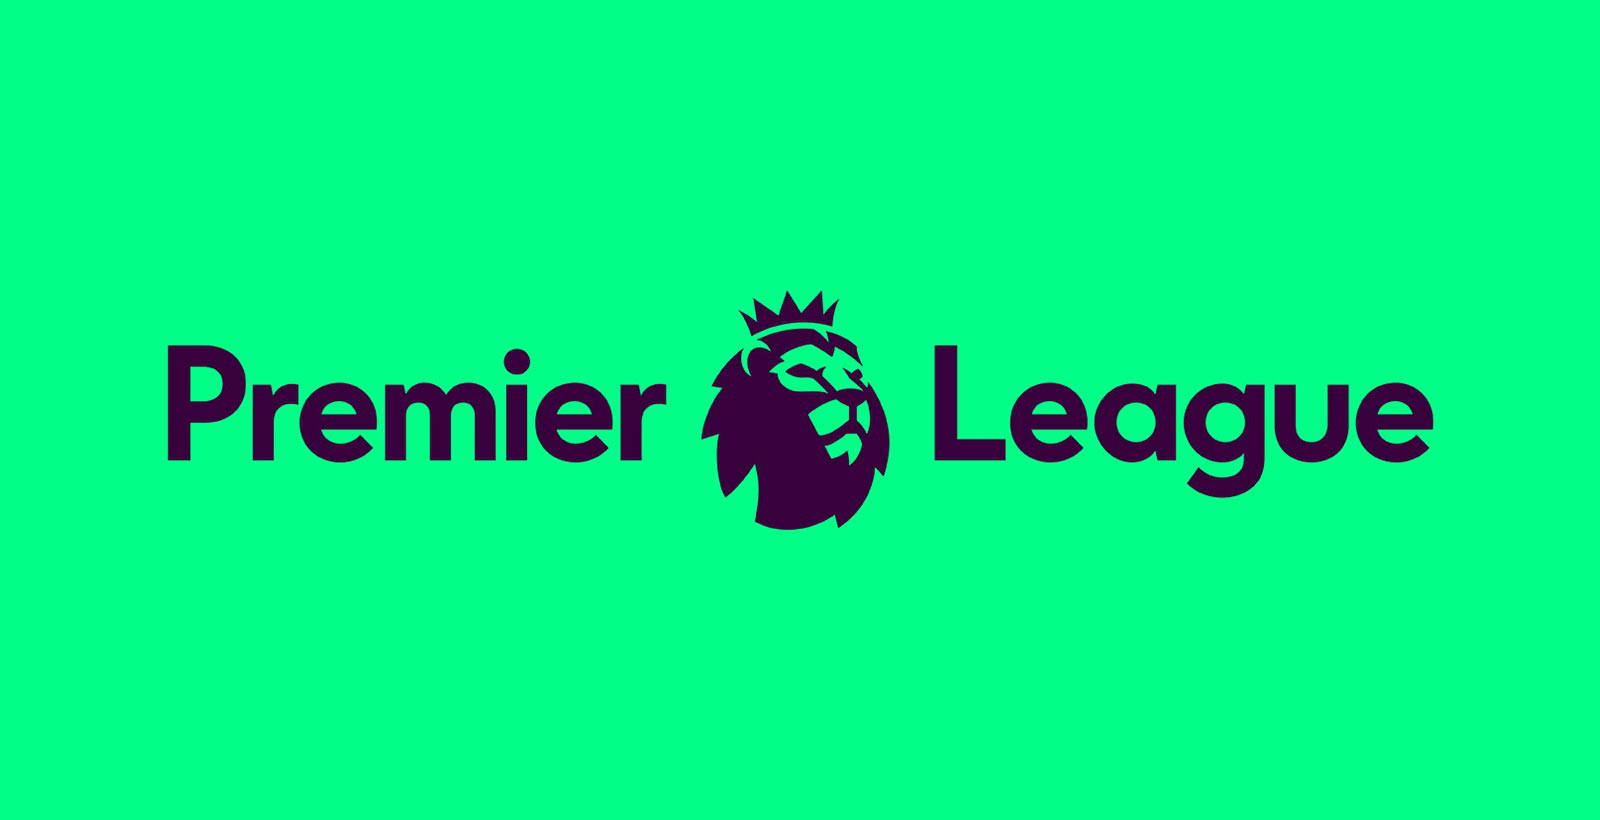

In [2]:
from PIL import Image
import requests
from io import BytesIO

response = requests.get('https://www.101greatgoals.com/wp-content/uploads/2017/03/new-premier-league-logo-2016-17-9.jpg')
img = Image.open(BytesIO(response.content))
img

## 1. Introdução

Dentre os campeonatos de futebol mais visualizados do mundo, a Premier League (Campeonato Inglês) tem se destacado por ser um campeonato de grande equilíbrio entre os times. Diferentemente de outros torneios Europeus, em que há majoritariamente a predominância de 1 ou 2 times, como aconteçe na Alemanha, Espanha e Itália, no torneio Inglês acontece uma rotatividade entre os campões nacionacias, como mostra a tabela abaixo:

In [3]:
df_Ligas = pd.read_excel('Ligas_Campeoes.xlsx')
df_Ligas.index = df_Ligas['Temporada']
df_Ligas.drop(columns = ['Temporada'], inplace = True)
df_Ligas

,Alemanha,Espanha,Itália,Inglaterra
Temporada,,,,
2019,Bayern München,Barcelona,Juventus,Manchester City
2018,Bayern München,Barcelona,Juventus,Manchester City
2017,Bayern München,Real Madrid,Juventus,Chelsea
2016,Bayern München,Barcelona,Juventus,Leicester City
2015,Bayern München,Barcelona,Juventus,Chelsea
2014,Bayern München,Atlético de Madrid,Juventus,Manchester City
2013,Bayern München,Barcelona,Juventus,Manchester United
2012,Borrusia Dortmund,Real Madrid,Juventus,Manchester City
2011,Borrusia Dortmund,Barcelona,Milan,Manchester United


Devido essa grande disputa, não só ocorre um aumento no público, como  também no número de apostas. Atualmente, é possível encontrar diversos sites de apostas que possuem partidas de futebol disponíveis para dar lances. Número de cartões amarelos, chutes ao gol ou quem será o ganhador da partida são alguns exemplos de apostas disponíveis. A partir dessa infinidade de itens, queremos responder: é possível prever qual será o ganhador de uma partidade de Futebol?


Para tentar responder ess apergunta, utilizou-se a base de dados do kaggle sobre os jogos da Premier League, além das informações sobre folha salarial disponibilizadas pelo site Sportrac.


Kaggle - https://www.kaggle.com/zaeemnalla/premier-league
Sportrac - https://www.spotrac.com/epl/payroll/

## 2. Construindo Banco de Dados

Para construir o modelo de previsão de jogos, teremos as variáveis "Mando da Partida", "Número de Gols produzidos", "Folha Salaria do Time" como dados de entrada. 
É notório que times com maior folha salárial tendem a desempenhar melhor em torneios de pontos corridos, visto que possuem os jogadores mais valiosos.
Também é de se esperar que o fator mando de campo também interferfira no resultado da partida, já que os jogadores terão apoio da torcida.
Por fim, a varíavel de número de gols produzidos é referente a quantos gols aquele time produziu até o momento daquela partida. Se um time faz mais gols em partidas anteriores, em teoria é mais provavel que ele ganhe a partida.

In [4]:
# Carregando Base de dados Kaggle
df = pd.read_csv('results.csv')
df.head()

,home_team,away_team,home_goals,away_goals,result,season
0,Sheffield United,Liverpool,1.0,1.0,D,2006-2007
1,Arsenal,Aston Villa,1.0,1.0,D,2006-2007
2,Everton,Watford,2.0,1.0,H,2006-2007
3,Newcastle United,Wigan Athletic,2.0,1.0,H,2006-2007
4,Portsmouth,Blackburn Rovers,3.0,0.0,H,2006-2007


In [5]:
# Alterando Cabeçalhos
dict = {
    'home_team' : 'Mandante',
    'away_team' : 'Visitante',
    'home_goals' : 'Gols_Mandante',
    'away_goals' : 'Gols_Visitante',
    'result': 'Resultado',
    'season': 'Temporada'
}

df = df.rename(columns = dict)
df.head()

,Mandante,Visitante,Gols_Mandante,Gols_Visitante,Resultado,Temporada
0,Sheffield United,Liverpool,1.0,1.0,D,2006-2007
1,Arsenal,Aston Villa,1.0,1.0,D,2006-2007
2,Everton,Watford,2.0,1.0,H,2006-2007
3,Newcastle United,Wigan Athletic,2.0,1.0,H,2006-2007
4,Portsmouth,Blackburn Rovers,3.0,0.0,H,2006-2007


Para criação do modelo, vamos trabalhar apenas com os dados de uma temporada, que nesse caso será a 2017-2018.

In [6]:
# Selecionando apenas temporada 2017-2018
selecao = df['Temporada'] == '2017-2018'
df = df[selecao]
df.head()

,Mandante,Visitante,Gols_Mandante,Gols_Visitante,Resultado,Temporada
4180,Arsenal,Leicester City,4.0,3.0,H,2017-2018
4181,Watford,Liverpool,3.0,3.0,D,2017-2018
4182,Chelsea,Burnley,2.0,3.0,A,2017-2018
4183,Crystal Palace,Huddersfield Town,0.0,3.0,A,2017-2018
4184,Everton,Stoke City,1.0,0.0,H,2017-2018


In [7]:
# Corrigindo o Index
index = [i for i in range(df.shape[0])]
index = np.array(index)
df.set_index(index, inplace = True)

In [8]:
# Adicionando as rodadas
rodada=[j+1 for j in range(38) for i in range(10)]
rodada = np.array(rodada)
df['Rodada'] = rodada
df.head()

,Mandante,Visitante,Gols_Mandante,Gols_Visitante,Resultado,Temporada,Rodada
0,Arsenal,Leicester City,4.0,3.0,H,2017-2018,1
1,Watford,Liverpool,3.0,3.0,D,2017-2018,1
2,Chelsea,Burnley,2.0,3.0,A,2017-2018,1
3,Crystal Palace,Huddersfield Town,0.0,3.0,A,2017-2018,1
4,Everton,Stoke City,1.0,0.0,H,2017-2018,1


### 2.1 Conferência de dados

Como na Premier League possui, 38 rodadas e 20 times, devemos ter 20 times repetindo 19 vezes para a coluna Mandante.

In [9]:
# Conferência do Número de Times
len(df['Mandante'].unique())

20

In [10]:
# Conferência do Número de Rodadas
df['Mandante'].value_counts()

Watford                     19
AFC Bournemouth             19
Everton                     19
Newcastle United            19
Manchester City             19
Brighton and Hove Albion    19
Chelsea                     19
West Bromwich Albion        19
Huddersfield Town           19
Liverpool                   19
Crystal Palace              19
Manchester United           19
Arsenal                     19
Leicester City              19
West Ham United             19
Swansea City                19
Tottenham Hotspur           19
Southampton                 19
Burnley                     19
Stoke City                  19
Name: Mandante, dtype: int64

### 2.2 Contruindo coluna Número de Gols 

In [11]:
# Array Nome Times
array_team_df = df['Mandante'].unique()
array_team_df.sort()
array_team_df

array(['AFC Bournemouth', 'Arsenal', 'Brighton and Hove Albion',
       'Burnley', 'Chelsea', 'Crystal Palace', 'Everton',
       'Huddersfield Town', 'Leicester City', 'Liverpool',
       'Manchester City', 'Manchester United', 'Newcastle United',
       'Southampton', 'Stoke City', 'Swansea City', 'Tottenham Hotspur',
       'Watford', 'West Bromwich Albion', 'West Ham United'], dtype=object)

In [12]:
# Construindo tabela com gols produzidos por cada time por rodada
lista = []
for time in array_team_df:
    selecao = (df['Mandante'] == time) | (df['Visitante'] == time)
    df_selecao = df[selecao]
    for i in range(38):
        if df_selecao.iloc[i,0] == time:
            lista.append(df_selecao.iloc[i,2])
        else:
            lista.append(df_selecao.iloc[i,3])
lista = np.array(lista)
lista = np.split(lista,20)
df_gols = pd.DataFrame(lista)
df_gols = df_gols.T
df_gols.columns = array_team_df

In [13]:
# Corrindo index
index = np.arange(1,39)
df_gols.set_index(index, inplace = True)
df_gols.columns.name = 'Rodada'
df_gols.head()

Rodada,AFC Bournemouth,Arsenal,Brighton and Hove Albion,Burnley,Chelsea,Crystal Palace,Everton,Huddersfield Town,Leicester City,Liverpool,Manchester City,Manchester United,Newcastle United,Southampton,Stoke City,Swansea City,Tottenham Hotspur,Watford,West Bromwich Albion,West Ham United
1,0.0,4.0,0.0,3.0,2.0,0.0,1.0,3.0,3.0,3.0,2.0,4.0,0.0,0.0,0.0,0.0,2.0,3.0,1.0,0.0
2,0.0,0.0,0.0,0.0,2.0,0.0,1.0,1.0,2.0,1.0,1.0,4.0,0.0,3.0,1.0,0.0,1.0,2.0,1.0,2.0
3,1.0,0.0,0.0,1.0,2.0,0.0,0.0,0.0,0.0,4.0,2.0,2.0,3.0,0.0,1.0,2.0,1.0,0.0,1.0,0.0
4,0.0,3.0,3.0,1.0,2.0,0.0,0.0,0.0,1.0,0.0,5.0,2.0,1.0,0.0,2.0,0.0,3.0,2.0,1.0,2.0
5,2.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,6.0,4.0,2.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0


In [14]:
# Somatório de Gols por Rodada
acumulado_gols = []
for time in range (20):
    for rodada in range(38):
        acumulado_gols.append(sum(df_gols.iloc[0:rodada,time]))

acumulado_gols = np.array(acumulado_gols)
acumulado_gols = np.split(acumulado_gols,20)
df_acumulado_gols = pd.DataFrame(acumulado_gols)
df_acumulado_gols = df_acumulado_gols.T
df_acumulado_gols.columns = array_team_df

# Corrigindo Index
index = np.arange(1,39)
df_acumulado_gols.set_index(index, inplace = True)
df_acumulado_gols.columns.name = 'Rodada'

In [15]:
# Somatório Gols times Mandantes
times = df_acumulado_gols.columns
times = np.array(times)
times = times.tolist()

lista_gols_mandantes = []
for i in range(380):
    nome_time = df['Mandante'][i]
    n_coluna = times.index(nome_time)
    n_linha = df.iloc[i, 6]
    lista_gols_mandantes.append(df_acumulado_gols.iloc[n_linha-1,n_coluna])
df['Acumulado_Gols_Mandante'] = lista_gols_mandantes

# Somatório Gols times Visitantes
lista_gols_visitantes = []
for i in range(380):
    nome_time = df['Visitante'][i]
    n_coluna = times.index(nome_time)
    n_linha = df.iloc[i, 6]
    lista_gols_visitantes.append(df_acumulado_gols.iloc[n_linha-1,n_coluna])
df['Acumulado_Gols_Visitante'] = lista_gols_visitantes
df.tail(10)

,Mandante,Visitante,Gols_Mandante,Gols_Visitante,Resultado,Temporada,Rodada,Acumulado_Gols_Mandante,Acumulado_Gols_Visitante
370,Burnley,AFC Bournemouth,1.0,2.0,A,2017-2018,38,35.0,43.0
371,Crystal Palace,West Bromwich Albion,2.0,0.0,H,2017-2018,38,43.0,31.0
372,Huddersfield Town,Arsenal,0.0,1.0,A,2017-2018,38,28.0,73.0
373,Liverpool,Brighton and Hove Albion,4.0,0.0,H,2017-2018,38,80.0,34.0
374,Manchester United,Watford,1.0,0.0,H,2017-2018,38,67.0,44.0
375,Newcastle United,Chelsea,3.0,0.0,H,2017-2018,38,36.0,62.0
376,Southampton,Manchester City,0.0,1.0,A,2017-2018,38,37.0,105.0
377,Swansea City,Stoke City,1.0,2.0,A,2017-2018,38,27.0,33.0
378,Tottenham Hotspur,Leicester City,5.0,4.0,H,2017-2018,38,69.0,52.0
379,West Ham United,Everton,3.0,1.0,H,2017-2018,38,45.0,43.0


Para ajudar o leitor, temos na tabela acima que na Rodada 38, ou seja, até a rodada 37, o time do Manchester City havia produzido 105 gols na temporada, enquanto o time do Everton produziu 37.
Ou seja , nós estamos olhando o histórico de gols produzidos até a rodada analisada para prever o resultado da partida.

In [16]:
# Colunas Diferenciais
df['Diferença_Gols_Mandante'] = df['Acumulado_Gols_Mandante']-df['Acumulado_Gols_Visitante']
df['Diferença_Gols_Visitante'] = df['Acumulado_Gols_Visitante']-df['Acumulado_Gols_Mandante']
df.head()

,Mandante,Visitante,Gols_Mandante,Gols_Visitante,Resultado,Temporada,Rodada,Acumulado_Gols_Mandante,Acumulado_Gols_Visitante,Diferença_Gols_Mandante,Diferença_Gols_Visitante
0,Arsenal,Leicester City,4.0,3.0,H,2017-2018,1,0.0,0.0,0.0,0.0
1,Watford,Liverpool,3.0,3.0,D,2017-2018,1,0.0,0.0,0.0,0.0
2,Chelsea,Burnley,2.0,3.0,A,2017-2018,1,0.0,0.0,0.0,0.0
3,Crystal Palace,Huddersfield Town,0.0,3.0,A,2017-2018,1,0.0,0.0,0.0,0.0
4,Everton,Stoke City,1.0,0.0,H,2017-2018,1,0.0,0.0,0.0,0.0


### 2.3. Base de Dados Salário

In [17]:
# Carregando Salários
df_Salary = pd.read_excel('Salary.xlsx')
df_Salary.sort_values(by = 'TEAM', inplace = True)
df_Salary.head()

,RANK,TEAM,ACTIVE PLAYERS,FORWARDS,MIDFIELDERS,DEFENSEMEN,GOALKEEPERS,TRANSFER FEES,EST. TOTAL SALARY
3,4,AFC Bournemouth,26,10320000,13520000,12623000,7280000,29160000,43743000
2,3,Arsenal F.C.,28,30527273,39312000,37284000,8320000,104320000,120643273
17,18,Brighton & Hove Albion,28,11622000,9360000,12896000,4680000,57230000,38558000
0,1,Burnley F.C.,27,8684000,14716000,8528000,4316000,34620000,36556000
1,2,Chelsea F.C.,29,14560000,52364000,39312000,8788000,238590000,115024000


In [18]:
# Array de Times 
array_team_df_Salary = df_Salary['TEAM'].unique()
array_team_df_Salary.sort()
array_team_df_Salary

array(['AFC Bournemouth', 'Arsenal F.C.', 'Brighton & Hove Albion',
       'Burnley F.C.', 'Chelsea F.C.', 'Crystal Palace', 'Everton F.C.',
       'Huddersfield Town', 'Leicester City', 'Liverpool F.C.',
       'Manchester City F.C.', 'Manchester United F.C.',
       'Newcastle United F.C.', 'Southampton F.C.', 'Stoke City F.C.',
       'Swansea City A.F.C.', 'Tottenham Hotspur F.C.', 'Watford',
       'West Bromwich Albion F.C.', 'West Ham United F.C.'], dtype=object)

In [19]:
# Comparação de nomes
df_times_names = pd.DataFrame({'Kaggle':array_team_df, 'Spotrac': array_team_df_Salary})
df_times_names

,Kaggle,Spotrac
0,AFC Bournemouth,AFC Bournemouth
1,Arsenal,Arsenal F.C.
2,Brighton and Hove Albion,Brighton & Hove Albion
3,Burnley,Burnley F.C.
4,Chelsea,Chelsea F.C.
5,Crystal Palace,Crystal Palace
6,Everton,Everton F.C.
7,Huddersfield Town,Huddersfield Town
8,Leicester City,Leicester City
9,Liverpool,Liverpool F.C.


In [20]:
# Criando Relação
relacao = np.array([array_team_df, array_team_df_Salary]) 

# Criando Dicionário
dict = {}
for j in range(relacao.shape[1]):
    dict[relacao[0,j]] = relacao[1,j]
    
print(dict)

{'AFC Bournemouth': 'AFC Bournemouth', 'Arsenal': 'Arsenal F.C.', 'Brighton and Hove Albion': 'Brighton & Hove Albion', 'Burnley': 'Burnley F.C.', 'Chelsea': 'Chelsea F.C.', 'Crystal Palace': 'Crystal Palace', 'Everton': 'Everton F.C.', 'Huddersfield Town': 'Huddersfield Town', 'Leicester City': 'Leicester City', 'Liverpool': 'Liverpool F.C.', 'Manchester City': 'Manchester City F.C.', 'Manchester United': 'Manchester United F.C.', 'Newcastle United': 'Newcastle United F.C.', 'Southampton': 'Southampton F.C.', 'Stoke City': 'Stoke City F.C.', 'Swansea City': 'Swansea City A.F.C.', 'Tottenham Hotspur': 'Tottenham Hotspur F.C.', 'Watford': 'Watford', 'West Bromwich Albion': 'West Bromwich Albion F.C.', 'West Ham United': 'West Ham United F.C.'}


In [21]:
# Substituindo nome em df
df['Mandantes'] = df.Mandante.map(dict)
df['Visitantes'] = df.Visitante.map(dict)
df.drop(columns = ['Mandante','Visitante', 'Gols_Mandante', 'Gols_Visitante'], inplace = True)
df.head()

,Resultado,Temporada,Rodada,Acumulado_Gols_Mandante,Acumulado_Gols_Visitante,Diferença_Gols_Mandante,Diferença_Gols_Visitante,Mandantes,Visitantes
0,H,2017-2018,1,0.0,0.0,0.0,0.0,Arsenal F.C.,Leicester City
1,D,2017-2018,1,0.0,0.0,0.0,0.0,Watford,Liverpool F.C.
2,A,2017-2018,1,0.0,0.0,0.0,0.0,Chelsea F.C.,Burnley F.C.
3,A,2017-2018,1,0.0,0.0,0.0,0.0,Crystal Palace,Huddersfield Town
4,H,2017-2018,1,0.0,0.0,0.0,0.0,Everton F.C.,Stoke City F.C.


In [22]:
# Dicionario Folha Salário
dict_salary = {}
for i in range(len(array_team_df_Salary)):
    dict_salary[array_team_df_Salary[i]] = df_Salary.iloc[i,3]
print (dict_salary)

{'AFC Bournemouth': 10320000, 'Arsenal F.C.': 30527273, 'Brighton & Hove Albion': 11622000, 'Burnley F.C.': 8684000, 'Chelsea F.C.': 14560000, 'Crystal Palace': 19240000, 'Everton F.C.': 22620000, 'Huddersfield Town': 8372000, 'Leicester City': 18980000, 'Liverpool F.C.': 21944000, 'Manchester City F.C.': 36712000, 'Manchester United F.C.': 29120000, 'Newcastle United F.C.': 13780000, 'Southampton F.C.': 18096000, 'Stoke City F.C.': 13468000, 'Swansea City A.F.C.': 7280000, 'Tottenham Hotspur F.C.': 15470000, 'Watford': 13104000, 'West Bromwich Albion F.C.': 16120000, 'West Ham United F.C.': 11960000}


In [23]:
# Construindo Coluna de Fola Salarial
df['Folha_Mandante'] = df.Mandantes.map(dict_salary)
df['Folha_Visitante'] = df.Visitantes.map(dict_salary)

In [24]:
# Diferença Salarial
df['D_Folha_Mandante'] = df['Folha_Mandante'] - df['Folha_Visitante']
df['D_Folha_Visitante'] = df['Folha_Visitante'] - df['Folha_Mandante']
df.head()

,Resultado,Temporada,Rodada,Acumulado_Gols_Mandante,Acumulado_Gols_Visitante,Diferença_Gols_Mandante,Diferença_Gols_Visitante,Mandantes,Visitantes,Folha_Mandante,Folha_Visitante,D_Folha_Mandante,D_Folha_Visitante
0,H,2017-2018,1,0.0,0.0,0.0,0.0,Arsenal F.C.,Leicester City,30527273,18980000,11547273,-11547273
1,D,2017-2018,1,0.0,0.0,0.0,0.0,Watford,Liverpool F.C.,13104000,21944000,-8840000,8840000
2,A,2017-2018,1,0.0,0.0,0.0,0.0,Chelsea F.C.,Burnley F.C.,14560000,8684000,5876000,-5876000
3,A,2017-2018,1,0.0,0.0,0.0,0.0,Crystal Palace,Huddersfield Town,19240000,8372000,10868000,-10868000
4,H,2017-2018,1,0.0,0.0,0.0,0.0,Everton F.C.,Stoke City F.C.,22620000,13468000,9152000,-9152000


### 2.4 Atribuindo placar

In [25]:
# Resultado
dict_resultado_mandante = {
    'H':2,
    'D':1,
    'A':0
}
dict_resultado_visitante = {
    'H':0,
    'D':1,
    'A':2
}
df['Score_Mandante'] = df.Resultado.map(dict_resultado_mandante)
df['Score_Visitante'] = df.Resultado.map(dict_resultado_visitante)
df.head()

,Resultado,Temporada,Rodada,Acumulado_Gols_Mandante,Acumulado_Gols_Visitante,Diferença_Gols_Mandante,Diferença_Gols_Visitante,Mandantes,Visitantes,Folha_Mandante,Folha_Visitante,D_Folha_Mandante,D_Folha_Visitante,Score_Mandante,Score_Visitante
0,H,2017-2018,1,0.0,0.0,0.0,0.0,Arsenal F.C.,Leicester City,30527273,18980000,11547273,-11547273,2,0
1,D,2017-2018,1,0.0,0.0,0.0,0.0,Watford,Liverpool F.C.,13104000,21944000,-8840000,8840000,1,1
2,A,2017-2018,1,0.0,0.0,0.0,0.0,Chelsea F.C.,Burnley F.C.,14560000,8684000,5876000,-5876000,0,2
3,A,2017-2018,1,0.0,0.0,0.0,0.0,Crystal Palace,Huddersfield Town,19240000,8372000,10868000,-10868000,0,2
4,H,2017-2018,1,0.0,0.0,0.0,0.0,Everton F.C.,Stoke City F.C.,22620000,13468000,9152000,-9152000,2,0


### 2.5 Empilhando dados

Para emplihar os dados, vamos selecionar times que jogaram em casa em 50 % das partidas e o 50% times que jogaram fora de casa nas partidas. Para facilitar,vamos determinar que caso a coluna possua um index par, analizaremos os times que estão jogando em casa. Para o index impar, analisarem os time visitante.

In [26]:
# Colunas Necessárias Casa, D_Folha_Casa, Result, selecionando metade dos dados (Colunas Pares)
df_ML = df[['Rodada', 'Mandantes', 'Acumulado_Gols_Mandante', 'Diferença_Gols_Mandante', 'Folha_Mandante', 'D_Folha_Mandante', 'Score_Mandante']][df.index%2 == 0]
df_ML['Mando_de_Campo'] = 1
df_ML.columns = ['Rodada','Time', 'Acumulado_Gols', 'Diferença_Gols', 'Folha', 'Diferença_Folha', 'Score', 'Mando_Campo']
df_ML.head()

,Rodada,Time,Acumulado_Gols,Diferença_Gols,Folha,Diferença_Folha,Score,Mando_Campo
0,1,Arsenal F.C.,0.0,0.0,30527273,11547273,2,1
2,1,Chelsea F.C.,0.0,0.0,14560000,5876000,0,1
4,1,Everton F.C.,0.0,0.0,22620000,9152000,2,1
6,1,West Bromwich Albion F.C.,0.0,0.0,16120000,5800000,2,1
8,1,Newcastle United F.C.,0.0,0.0,13780000,-1690000,0,1


In [27]:
# Colunas Necessárias Casa, D_Folha_Casa, Result, selecionando metade dos dados (Colunas Pares)
df_ML_1 = df[['Rodada', 'Visitantes', 'Acumulado_Gols_Visitante', 'Diferença_Gols_Visitante', 'Folha_Visitante', 'D_Folha_Visitante', 'Score_Visitante']][df.index%2 == 1]
df_ML_1['Mando_de_Campo'] = 0
df_ML_1.columns = ['Rodada','Time', 'Acumulado_Gols', 'Diferença_Gols', 'Folha', 'Diferença_Folha', 'Score', 'Mando_Campo']
df_ML_1.head()

,Rodada,Time,Acumulado_Gols,Diferença_Gols,Folha,Diferença_Folha,Score,Mando_Campo
1,1,Liverpool F.C.,0.0,0.0,21944000,8840000,1,0
3,1,Huddersfield Town,0.0,0.0,8372000,-10868000,2,0
5,1,Swansea City A.F.C.,0.0,0.0,7280000,-10816000,1,0
7,1,Manchester City F.C.,0.0,0.0,36712000,25090000,2,0
9,1,West Ham United F.C.,0.0,0.0,11960000,-17160000,0,0


In [28]:
# Empilhando dados
Consolidado = [df_ML,df_ML_1]
Resultado = pd.concat(Consolidado)
Resultado.head()

,Rodada,Time,Acumulado_Gols,Diferença_Gols,Folha,Diferença_Folha,Score,Mando_Campo
0,1,Arsenal F.C.,0.0,0.0,30527273,11547273,2,1
2,1,Chelsea F.C.,0.0,0.0,14560000,5876000,0,1
4,1,Everton F.C.,0.0,0.0,22620000,9152000,2,1
6,1,West Bromwich Albion F.C.,0.0,0.0,16120000,5800000,2,1
8,1,Newcastle United F.C.,0.0,0.0,13780000,-1690000,0,1


## 3. Criando Modelo de MachineLearning

### 3.1. Analise Comportamento de Dados

Para entender como é o comportamento das 3 variáveis analisadas vamos contruir gráficos de dispersão. Lembrando que os números 0,1,2 representam Derrota, Empate e Vitória respectivamente.

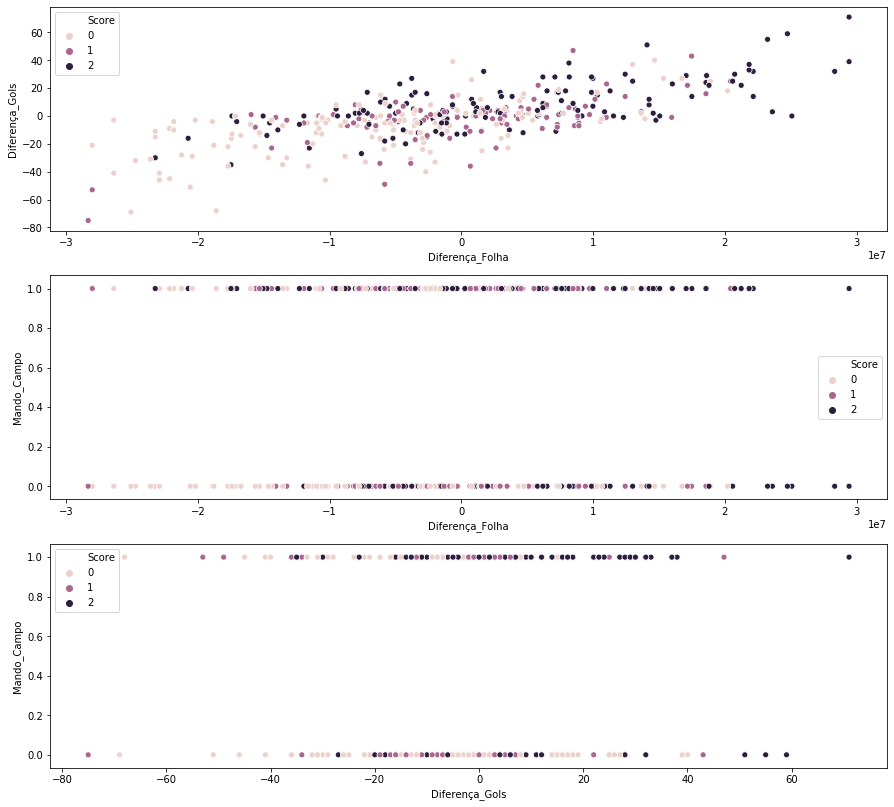

In [29]:
plt.rc('figure', figsize = (15,14))
fig, ax =plt.subplots(3,1)

sns.scatterplot(x='Diferença_Folha', y='Diferença_Gols',  hue='Score', data=Resultado, ax=ax[0]) 
sns.scatterplot(x='Diferença_Folha', y='Mando_Campo',  hue='Score', data=Resultado, ax=ax[1]) 
sns.scatterplot(x='Diferença_Gols', y='Mando_Campo',  hue='Score', data=Resultado, ax=ax[2])

O gráfico 1 reafirma a importância dos número de gols e folha salarial, já que há uma concentração de bolas pretas (Vitórias) no canto superior esquerdo do gráfico. O mando de campo também demonstrar ser um atributo relevante, visto existe um maior concentração de bolas pretas(Vitórias) em situações em que o time foi o mandante.

### 3.2. Modelo Linear SVC

### 3.2.1. Definindo Variáveis

Em um primeiro momento vamos utilizar apenas os atributos 'Diferença_Gols' e 'Diferença_Folha', para que possamos desenhar a barreira de decisão.

In [30]:
X = Resultado[['Diferença_Gols', 'Diferença_Folha']]
y = Resultado['Score']

### 3.2.2. Contruindo Modelo

In [31]:
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score

# Definido semente Padrão
SEED = 39
np.random.seed(SEED)

# Dividindo amostra em treino e teste
treino_x, teste_x, treino_y, teste_y = train_test_split(X, y,
                                                         test_size = 0.25,
                                                         stratify = y)
print("Treinaremos com %d elementos e testaremos com %d elementos" % (len(treino_x), len(teste_x)))

# Criando modelo 
modelo = LinearSVC()
modelo.fit(treino_x, treino_y)
previsoes = modelo.predict(teste_x)

# Calculando Acuracia do Modelo
acuracia = accuracy_score(teste_y, previsoes) * 100
print("A acurácia foi %.2f%%" % acuracia)

Treinaremos com 285 elementos e testaremos com 95 elementos
A acurácia foi 23.16%


C:\Users\PC\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


### 3.2.3. Contruindo Barreira de Decisão 

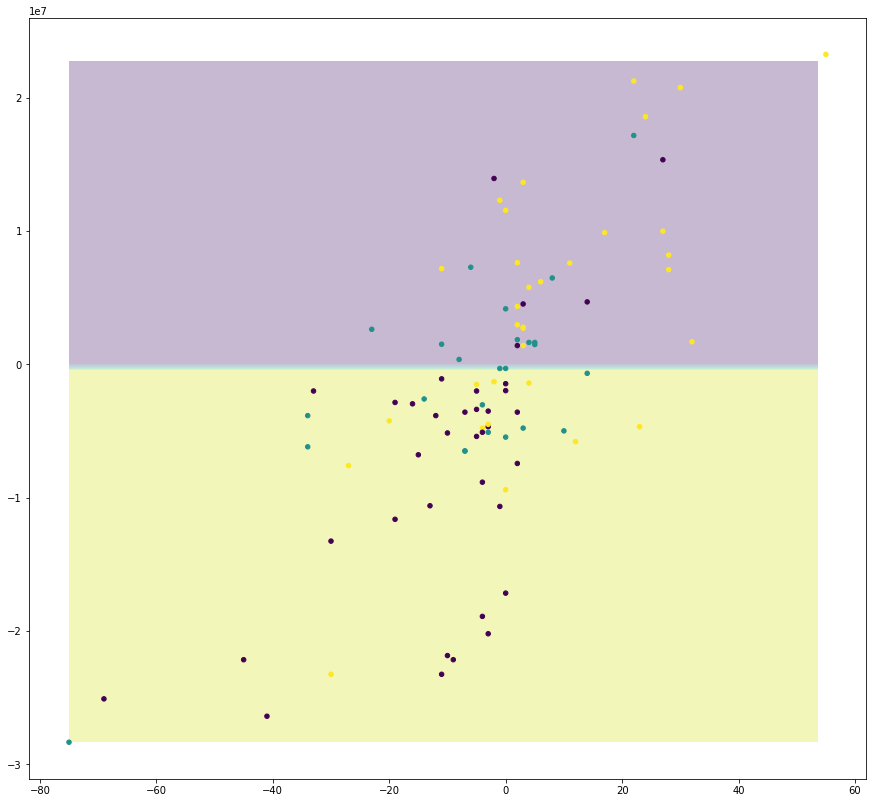

In [32]:
x_min = teste_x.Diferença_Gols.min()
x_max = teste_x.Diferença_Gols.max()
y_min = teste_x.Diferença_Folha.min()
y_max = teste_x.Diferença_Folha.max()

pixels = 100
eixo_x = np.arange(x_min, x_max, (x_max - x_min) / pixels)
eixo_y = np.arange(y_min, y_max, (y_max - y_min) / pixels)

xx, yy = np.meshgrid(eixo_x, eixo_y)
pontos = np.c_[xx.ravel(), yy.ravel()]

Z = modelo.predict(pontos)
Z = Z.reshape(xx.shape)

import matplotlib.pyplot as plt

plt.contourf(xx, yy, Z, alpha=0.3)
ax = plt.scatter(teste_x.Diferença_Gols, teste_x.Diferença_Folha, c=teste_y, s=20)

Apenas pela imagem acima, é possível verificar que a decisão do modelo foi quase igual a dividir a amortra no meio, e prever vitória para quem estiver acima e derrota para os que estiverem abaixo. A acurácia foi igual a 23,16%, ou seja, aparentemente ínfima.
Mas quão ruim foi a previsão desse modelo? Necessitamos ter uma base para saber classificar o nosso resultado.

### 3.2.4. Dummy Classifier

Esse estimador irá prever qual é acurácia do modelo caso optamos por chutar o valor que mais se repete (nesse caso foi a Vitória). Isto é, prevendo que todos os times analisado fossem sair vitoriosos das partidas, qual seria o percentual de acerto do nosso modelo?

In [33]:
# Comparando a acurácia
from sklearn.dummy import DummyClassifier

dummy = DummyClassifier(strategy='most_frequent')
dummy.fit(treino_x, treino_y)
acuracia = dummy.score(teste_x, teste_y) * 100

print("A acurácia do dummy foi %.2f%%" % acuracia)

A acurácia do dummy foi 38.95%


### 3.3. Modelo SVC

### 3.3.1. Definindo Variáveis

In [34]:
X = Resultado[['Diferença_Gols', 'Diferença_Folha']]
y = Resultado['Score']

### 3.3.2. Construindo Modelo

In [35]:
# Utilizando modelo Machine Learning
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

# Definido semente Padrão
SEED = 39
np.random.seed(SEED)

# Dividindo amostra em treino e teste
raw_treino_x, raw_teste_x, treino_y, teste_y = train_test_split(X, y, test_size = 0.25,
                                                         stratify = y)
print("Treinaremos com %d elementos e testaremos com %d elementos" % (len(raw_treino_x), len(raw_teste_x)))

# Normalizador
scaler = StandardScaler()
scaler.fit(raw_treino_x)
treino_x = scaler.transform(raw_treino_x)
teste_x = scaler.transform(raw_teste_x)

# Criando modelo
modelo = SVC()
modelo.fit(treino_x, treino_y)
previsoes = modelo.predict(teste_x)

# Calcuando acurácia do Modelo
acuracia = accuracy_score(teste_y, previsoes) * 100
print("A acurácia foi %.2f%%" % acuracia)


Treinaremos com 285 elementos e testaremos com 95 elementos
A acurácia foi 50.53%


### 3.3.3. Construindo Barreira de Decisão

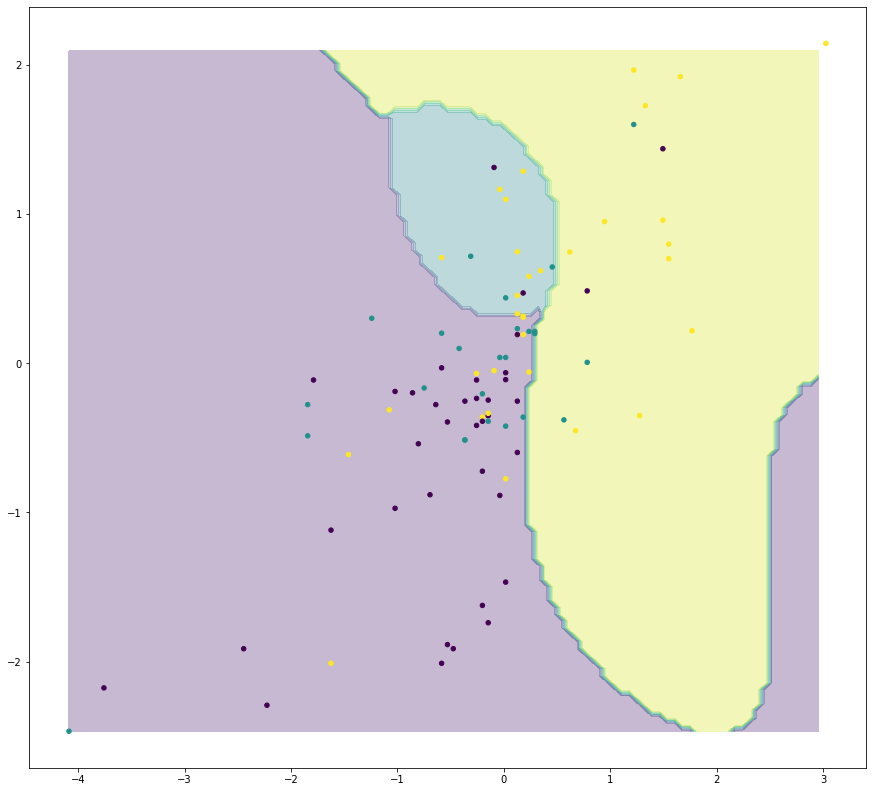

In [36]:
data_x = teste_x[:,0]
data_y = teste_x[:,1]

x_min = data_x.min()
x_max = data_x.max()
y_min = data_y.min()
y_max = data_y.max()

pixels = 100
eixo_x = np.arange(x_min, x_max, (x_max - x_min) / pixels)
eixo_y = np.arange(y_min, y_max, (y_max - y_min) / pixels)

xx, yy = np.meshgrid(eixo_x, eixo_y)
pontos = np.c_[xx.ravel(), yy.ravel()]

Z = modelo.predict(pontos)
Z = Z.reshape(xx.shape)

import matplotlib.pyplot as plt

plt.contourf(xx, yy, Z, alpha=0.3)
plt.scatter(data_x, data_y, c=teste_y, s=20)

No gráfico acima, conseguimos perceber a diferença do modelo SVC, em que o modelo não fica restrito ao traado de linhas. É possível verificar 3 áreas claras de tomada de decisão, sendo roxa (derrota), verde (empate), amarela (Vitória). Como foi possível observar seção do comportamento de dados, quanto mais acima e a direita do gráfico, mais proválvel é a vitória. O oposto também segue a lógica. E na região central do gráfico o modelo definiu a área de empate. Entretanto, ainda que a acurácia teha subido para 50,53% ainda é elevado o número de pontos de coloração diferente da área que está incluído.

Logo, iremos utilizar a variável 'Mando_Campo' tentar aumentar a acurácia.

### 3.3.4 Adiconando 3° Atributo

In [37]:
# Definindo X e y
X = Resultado[['Diferença_Gols', 'Diferença_Folha', 'Mando_Campo']]
y = Resultado['Score']

In [38]:
# Utilizando modelo Machine Learning
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

# Definido semente Padrão
SEED = 39
np.random.seed(SEED)

# Dividindo amostra em treino e teste
raw_treino_x, raw_teste_x, treino_y, teste_y = train_test_split(X, y, test_size = 0.25,
                                                         stratify = y)

# Normalizador
scaler = StandardScaler()
scaler.fit(raw_treino_x)
treino_x = scaler.transform(raw_treino_x)
teste_x = scaler.transform(raw_teste_x)

# Criando modelo
modelo = SVC()
modelo.fit(treino_x, treino_y)
previsoes = modelo.predict(teste_x)

# Calcuando acurácia do Modelo
acuracia = accuracy_score(teste_y, previsoes) * 100
print("A acurácia foi %.2f%%" % acuracia)

A acurácia foi 57.89%


A acurácia teve um aumento considerável ao introduzirmos o atributo mando de campo. No entanto, com essa adição não é possível desenha o gráfico da barreira de decissão. Ou seja, não conseguimos vizualizar de que forma o modelo faz a tomada de decisão.

### 3.4. Modelo Árvore de Decisão

### 3.4.1. Definindo Variáveis

In [39]:
# Definindo X e y
X = Resultado[['Diferença_Gols', 'Diferença_Folha', 'Mando_Campo']]
y = Resultado['Score']

### 3.4.2. Construindo Modelo

In [40]:
# Utilizando modelo Machine Learning
from sklearn.tree import DecisionTreeClassifier

# Definido semente Padrão
SEED = 39
np.random.seed(SEED)

# Dividindo amostra em treino e teste
raw_treino_x, raw_teste_x, treino_y, teste_y = train_test_split(X, y, test_size = 0.25,
                                                         stratify = y)
print("Treinaremos com %d elementos e testaremos com %d elementos" % (len(treino_x), len(teste_x)))

# Criando modelo
modelo = DecisionTreeClassifier(max_depth=2)
modelo.fit(raw_treino_x, treino_y)
previsoes = modelo.predict(raw_teste_x)

# Calcuando acurácia do Modelo
acuracia = accuracy_score(teste_y, previsoes) * 100
print("A acurácia foi %.2f%%" % acuracia)


Treinaremos com 285 elementos e testaremos com 95 elementos
A acurácia foi 54.74%


### 3.4.3. Árvore de Decisão

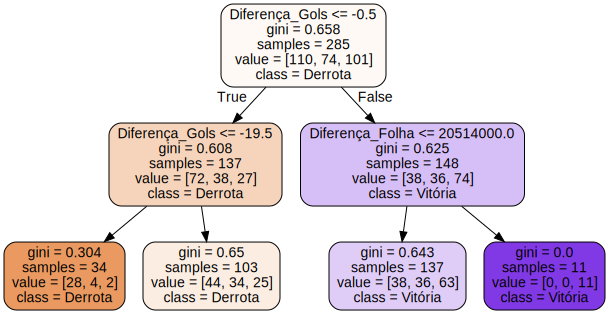

In [41]:
from sklearn.tree import export_graphviz
import graphviz

features = X.columns
dot_data = export_graphviz(modelo, out_file=None,
                           filled = True, rounded = True,
                           feature_names = features,
                          class_names = ["Derrota", "Empate","Vitória"])
grafico = graphviz.Source(dot_data)
grafico

## 5. Comparação de Modelos

In [42]:
df_Modelos = pd.read_excel('Modelos.xlsx')
df_Modelos.index = df_Modelos['Modelo']
df_Modelos.drop(columns = ['Modelo'], inplace = True)
df_Modelos

,Linear SVC,Dummy Classifier,SVC - 2 Variáveis,SVC - 3 Variáveis,Árvore de Decisão
Modelo,,,,,
Acurácia,0.2316,0.3895,0.5053,0.5789,0.5474


## 6. Conclusão

Embora o modelo SVC tenha apresentado melhor acurácia (57,89%) , ao utilizar essa ferramenta com >2 variáveis, não é possível traçar o gráfico de barreira de decisão. Ou seja, caímos em um blackbox, em que não é possível ratrear como foi escolhida a tomada de decisão. 

Para aumentar a acurácia do modelo acredito que ouras variáveis de entrada podem ser acrescentadas, como número de gols sofridos por time (ponderando as melhores defesas) e valor do time que entrou em campo (ponderar a situação em que reservas são utilizados).